In [4]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Load the cleaned + encoded dataset
file_path = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/crypto_news_with_sentiment_encoded.xlsx"
df = pd.read_excel(file_path)

# Step 2: Load trained model and vectorizer
model = joblib.load("sentiment_model_nb.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Step 3: Preprocess titles (cleaning should be same as during training)
import string, re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

df["clean_text"] = df["title"].astype(str).apply(clean_text)

# Step 4: Transform using TF-IDF
X_transformed = vectorizer.transform(df["clean_text"])

# Step 5: Predict
predictions = model.predict(X_transformed)

# Step 6: Add predictions to DataFrame
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df["predicted_sentiment"] = [label_map[p] for p in predictions]

#  Step 7: Save to new file
output_path = file_path.replace(".xlsx", "_with_predictions.xlsx")
df.to_excel(output_path, index=False)
print(f"Predictions saved to: {output_path}")

# Step 8: Evaluate
print("\nEvaluation Metrics:")
print("Accuracy:", accuracy_score(df['sentiment_encoded'], predictions))
print("\nClassification Report:")
print(classification_report(df['sentiment_encoded'], predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(df['sentiment_encoded'], predictions))

Predictions saved to: /Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/crypto_news_with_sentiment_encoded_with_predictions.xlsx

Evaluation Metrics:
Accuracy: 0.7407407407407407

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.49      0.66       544
           1       0.66      1.00      0.80      1197
           2       0.98      0.47      0.63       635

    accuracy                           0.74      2376
   macro avg       0.87      0.65      0.70      2376
weighted avg       0.82      0.74      0.72      2376


Confusion Matrix:
[[ 269  269    6]
 [   3 1193    1]
 [   5  332  298]]


Combined DataFrame:


,crypto_name,news_count,price_usd,change_24h,market_cap_usd,volume_24h_usd
0,Bitcoin,369,3.077,-12.7,0.0,0.0
1,Ripple,12,3.077,-33.9,0.0,0.0
2,Dogecoin,3,3.077,-76.0,0.0,0.0
3,Polkadot,2,3.077,-92.4,0.0,0.0
4,Solana,9,3.077,-49.7,0.0,0.0
5,Cardano,2,3.077,-77.3,0.0,0.0
6,Ethereum,26,3.077,-62.9,0.0,0.0
7,Litecoin,3,3.077,-79.0,0.0,0.0
8,Chainlink,1,3.077,-72.1,0.0,0.0
9,Binance Coin,5,3.077,-23.4,0.0,0.0


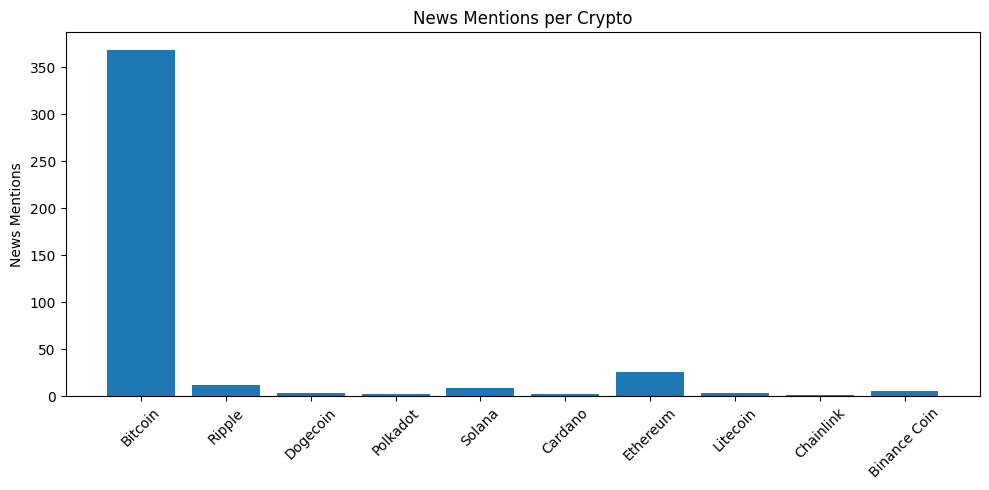

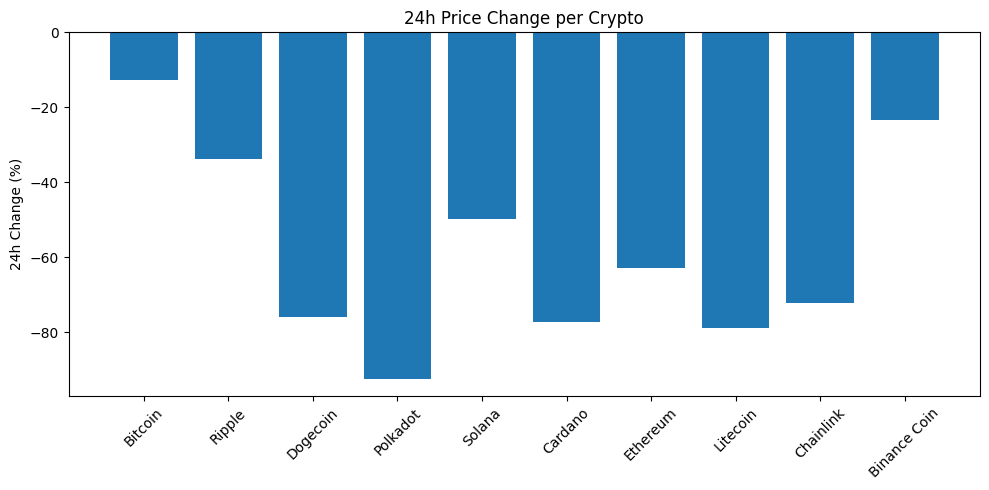

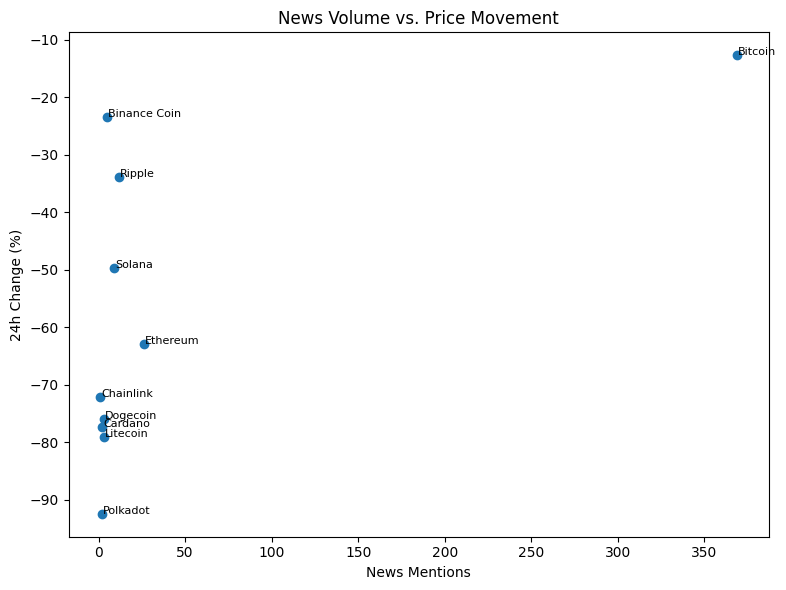

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# ─── 1) Load your four data files (fixed paths) ────────────────────────────────
reddit      = pd.read_csv('/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /reddit_crypto_bulk_tagged.csv')
cointele    = pd.read_excel('/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /cointelegraph_bitcoin_scroll_fixed.xlsx')
cryptoslate = pd.read_excel('/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /cryptoslate_articles_wpapi.xlsx')
prices      = pd.read_csv('/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /crypto_prices.csv')

# ─── 2) Rename & normalize crypto_name columns ──────────────────────────────────
reddit.rename(columns={'detected_coins':'crypto_name'}, inplace=True)
# cointele and cryptoslate already have 'crypto_name', prices too

# ─── 3) Parse dates ─────────────────────────────────────────────────────────────
reddit['date']      = pd.to_datetime(reddit['created_utc']).dt.date
cointele['date']    = pd.to_datetime(cointele['scraped_at']).dt.date
cryptoslate['date'] = pd.to_datetime(cryptoslate['date']).dt.date

# ─── 4) Build unified (crypto_name, date) list ─────────────────────────────────
all_news = pd.concat([
    reddit[['crypto_name','date']],
    cointele[['crypto_name','date']],
    cryptoslate[['crypto_name','date']]
], ignore_index=True)

# ─── 5) Count headlines per crypto ─────────────────────────────────────────────
news_count = (
    all_news
    .groupby("crypto_name")
    .size()
    .reset_index(name="news_count")
)

# ─── 6) Merge with price metrics ────────────────────────────────────────────────
df = pd.merge(news_count, prices, on="crypto_name", how="right").fillna(0)

# ─── 7) Display the combined table ──────────────────────────────────────────────
print("Combined DataFrame:")
display(df)

# ─── 8) Plot A: News Mentions per Crypto ────────────────────────────────────────
plt.figure(figsize=(10,5))
plt.bar(df["crypto_name"], df["news_count"])
plt.xticks(rotation=45)
plt.ylabel("News Mentions")
plt.title("News Mentions per Crypto")
plt.tight_layout()
plt.show()

# ─── 9) Plot B: 24h Price Change per Crypto ────────────────────────────────────
plt.figure(figsize=(10,5))
plt.bar(df["crypto_name"], df["change_24h"])
plt.xticks(rotation=45)
plt.ylabel("24h Change (%)")
plt.title("24h Price Change per Crypto")
plt.tight_layout()
plt.show()

# ─── 10) Plot C: Scatter News vs. Price Change ─────────────────────────────────
plt.figure(figsize=(8,6))
plt.scatter(df["news_count"], df["change_24h"])
for _, row in df.iterrows():
    plt.text(row["news_count"]+0.5, row["change_24h"], row["crypto_name"], fontsize=8)
plt.xlabel("News Mentions")
plt.ylabel("24h Change (%)")
plt.title("News Volume vs. Price Movement")
plt.tight_layout()
plt.show()
